<a href="https://colab.research.google.com/github/swethaselvarajm/Miniproject/blob/main/final_MINI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages and setup
!pip install matplotlib seaborn statsmodels plotly
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [ ]:
# Load and Clean Dataset
file_path = '/content/CrimesOnWomenData-dataset.csv'  # Replace with your dataset path
df = pd.read_csv(file_path)
data_cleaned = df.drop(columns=['Unnamed: 0'])  # Remove unnecessary column
statewise_data = data_cleaned.groupby(['State', 'Year']).sum().reset_index()

# Define the crime types
crime_types = ['Rape', 'Kidnapping and Abduction', 'Dowry Deaths',
               'Assault on women with intent to outrage her modesty',
               'Insult to modesty of Women', 'Cruelty by Husband or his Relatives']


In [ ]:
# Standardize state names
df.loc[df['State'] == 'A&N Islands', 'State'] = 'A & N ISLANDS'
df.loc[df['State'] == 'D&N Haveli', 'State'] = 'D & N HAVELI'
df.loc[df['State'] == 'Delhi UT', 'State'] = 'DELHI'
df['State'] = df['State'].str.upper()  # Convert all states to uppercase


In [ ]:
# View initial data details
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 10 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Unnamed: 0                                           736 non-null    int64 
 1   State                                                736 non-null    object
 2   Year                                                 736 non-null    int64 
 3   Rape                                                 736 non-null    int64 
 4   Kidnapping and Abduction                             736 non-null    int64 
 5   Dowry Deaths                                         736 non-null    int64 
 6   Assault on women with intent to outrage her modesty  736 non-null    int64 
 7   Insult to modesty of Women                           736 non-null    int64 
 8   Cruelty by Husband or his Relatives                  736 non-null    int64 
 9  

In [ ]:
print(df.describe(include='all'))


        Unnamed: 0           State         Year         Rape  \
count   736.000000             736   736.000000   736.000000   
unique         NaN              36          NaN          NaN   
top            NaN  ANDHRA PRADESH          NaN          NaN   
freq           NaN              21          NaN          NaN   
mean    367.500000             NaN  2011.149457   727.855978   
std     212.609188             NaN     6.053453   977.024945   
min       0.000000             NaN  2001.000000     0.000000   
25%     183.750000             NaN  2006.000000    35.000000   
50%     367.500000             NaN  2011.000000   348.500000   
75%     551.250000             NaN  2016.000000  1069.000000   
max     735.000000             NaN  2021.000000  6337.000000   

        Kidnapping and Abduction  Dowry Deaths  \
count                 736.000000    736.000000   
unique                       NaN           NaN   
top                          NaN           NaN   
freq                         Na

In [ ]:
print("Unique States:", df['State'].unique())


Unique States: ['ANDHRA PRADESH' 'ARUNACHAL PRADESH' 'ASSAM' 'BIHAR' 'CHHATTISGARH' 'GOA'
 'GUJARAT' 'HARYANA' 'HIMACHAL PRADESH' 'JAMMU & KASHMIR' 'JHARKHAND'
 'KARNATAKA' 'KERALA' 'MADHYA PRADESH' 'MAHARASHTRA' 'MANIPUR' 'MEGHALAYA'
 'MIZORAM' 'NAGALAND' 'ODISHA' 'PUNJAB' 'RAJASTHAN' 'SIKKIM' 'TAMIL NADU'
 'TRIPURA' 'UTTAR PRADESH' 'UTTARAKHAND' 'WEST BENGAL' 'A & N ISLANDS'
 'CHANDIGARH' 'D & N HAVELI' 'DAMAN & DIU' 'LAKSHADWEEP' 'PUDUCHERRY'
 'TELANGANA' 'DELHI']


In [ ]:
# Storing the sum of all crimes committed within a state (statewise)
state_all_crimes = df.groupby('State').sum()

# Dropping the sum of year column
state_all_crimes.drop('Year', axis=1, inplace=True)

# Adding a column containing the total crime against women in that state
col_list = list(state_all_crimes)

# Convert columns to numeric, coerce errors to NaN to ensure compatibility for summation
state_all_crimes[col_list] = state_all_crimes[col_list].apply(pd.to_numeric, errors='coerce')

# Now you can sum across rows
state_all_crimes['Total'] = state_all_crimes[col_list].sum(axis=1)

# Assigning to all_crimes
all_crimes = state_all_crimes

all_crimes

,Unnamed: 0,Rape,Kidnapping and Abduction,Dowry Deaths,Assault on women with intent to outrage her modesty,Insult to modesty of Women,Cruelty by Husband or his Relatives,Importation of Girls,Total
State,,,,,,,,,
A & N ISLANDS,7849,424,363,13,558,135,365,10,9717
ANDHRA PRADESH,7250,23424,21707,8165,92084,54684,188511,2548,398373
ARUNACHAL PRADESH,7271,1153,1272,4,1584,97,705,7,12093
ASSAM,7292,32190,71462,2757,47115,2698,135415,343,299272
BIHAR,7313,21006,77687,24428,9953,800,55187,825,197199
CHANDIGARH,7870,795,1547,68,954,281,1689,7,13211
CHHATTISGARH,7334,25178,16536,1797,33310,4382,16381,103,105021
D & N HAVELI,7891,2343,7148,256,3977,840,7349,12,29816
DAMAN & DIU,7912,619,1725,30,3642,58,912,29,14927


In [ ]:
#sorting the statewise crime from highest to lowest
state_all_crimes.sort_values('Total',ascending=False)
state_all_crimes

,Unnamed: 0,Rape,Kidnapping and Abduction,Dowry Deaths,Assault on women with intent to outrage her modesty,Insult to modesty of Women,Cruelty by Husband or his Relatives,Importation of Girls,Total
State,,,,,,,,,
A & N ISLANDS,7849,424,363,13,558,135,365,10,9717
ANDHRA PRADESH,7250,23424,21707,8165,92084,54684,188511,2548,398373
ARUNACHAL PRADESH,7271,1153,1272,4,1584,97,705,7,12093
ASSAM,7292,32190,71462,2757,47115,2698,135415,343,299272
BIHAR,7313,21006,77687,24428,9953,800,55187,825,197199
CHANDIGARH,7870,795,1547,68,954,281,1689,7,13211
CHHATTISGARH,7334,25178,16536,1797,33310,4382,16381,103,105021
D & N HAVELI,7891,2343,7148,256,3977,840,7349,12,29816
DAMAN & DIU,7912,619,1725,30,3642,58,912,29,14927


In [ ]:
# Exploratory Data Analysis (EDA)
# 1. Aggregate state-level data for overall analysis
state_all_crimes = df.groupby('State').sum()
state_all_crimes.drop('Year', axis=1, inplace=True)
state_all_crimes['Total'] = state_all_crimes.sum(axis=1)


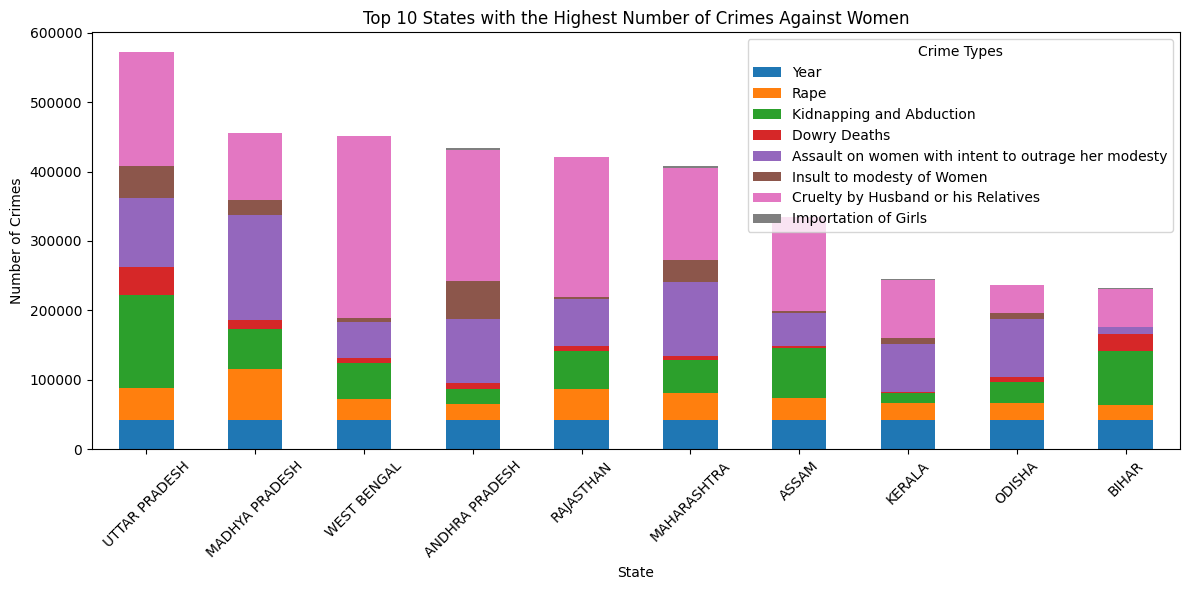

In [ ]:
# Fixing and grouping the data by state
state_all_crimes = df.groupby('State').sum(numeric_only=True)  # Ensure only numeric columns are summed
state_all_crimes['Total'] = state_all_crimes.sum(axis=1)

# Sorting states by total crimes
top_states = state_all_crimes.sort_values('Total', ascending=False).head(10)

# Plotting the data
plt.figure(figsize=(12, 6))
top_states.drop(columns=['Total']).plot(kind='bar', stacked=True, ax=plt.gca())  # Exclude 'Total' from the plot
plt.title('Top 10 States with the Highest Number of Crimes Against Women')
plt.xlabel('State')
plt.ylabel('Number of Crimes')
plt.xticks(ticks=range(len(top_states)), labels=top_states.index, rotation=45)
plt.legend(title="Crime Types")
plt.tight_layout()
plt.show()


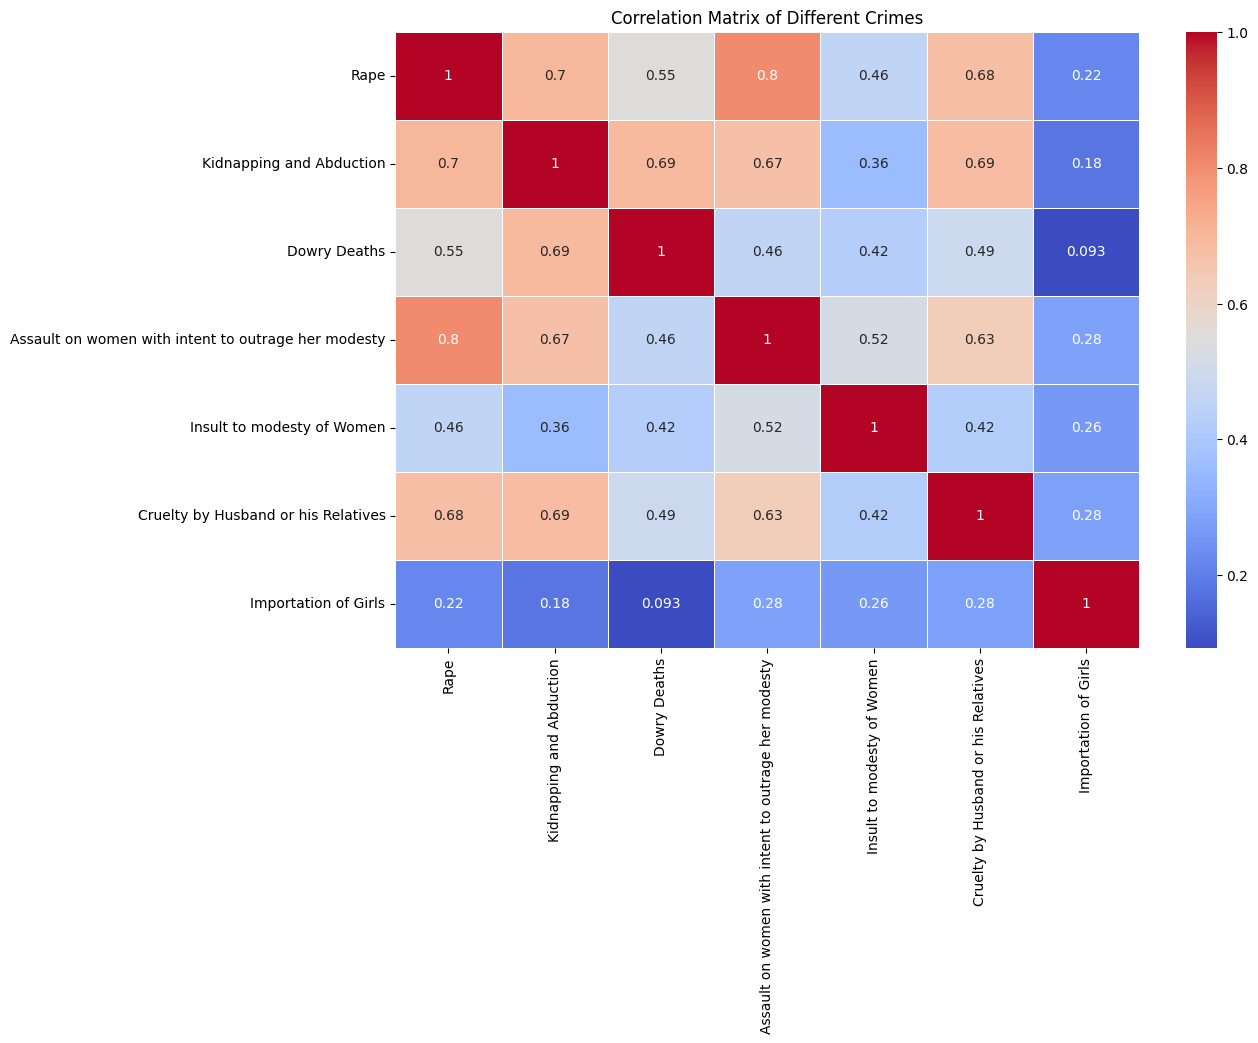

In [ ]:
# 3. Correlation Matrix
correlation_matrix = df.drop(['State', 'Year'], axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Different Crimes')
plt.show()


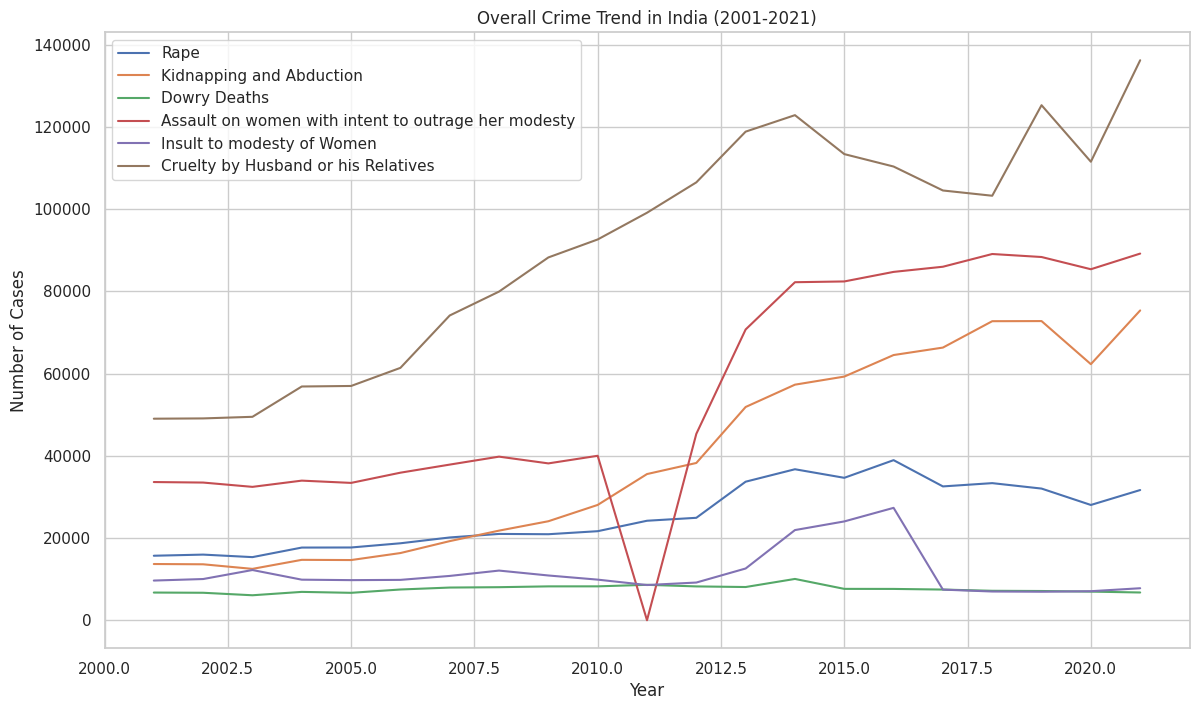

In [ ]:
def plot_overall_crime_trend():
    sns.set(style="whitegrid")


    # Aggregate by year for overall trend
    overall_trend = statewise_data.groupby('Year')[crime_types].sum().reset_index()


    # Plot each crime type over the years
    plt.figure(figsize=(14, 8))
    for crime in crime_types:
        plt.plot(overall_trend['Year'], overall_trend[crime], label=crime)


    plt.title('Overall Crime Trend in India (2001-2021)')
    plt.xlabel('Year')
    plt.ylabel('Number of Cases')
    plt.legend(loc='upper left')
    plt.show()
plot_overall_crime_trend()

In [ ]:
# Step 4: Holt-Winters Forecasting for All Crime Types (Forecast for a Specific Year for All States)
def holt_winters_forecasting_all_states(forecast_year):
    all_forecasted_results = {}

    # Get unique list of states in original order
    states = df['State'].unique()

    # Forecasting for each state and each crime type
    for state in states:
        forecasted_results = {}

        for crime_type in crime_types:
            # Filter data for the selected state and crime type
            state_data = statewise_data[statewise_data['State'] == state][['Year', crime_type]].set_index('Year')

            # Check if state_data is empty
            if state_data.empty:
                forecasted_results[crime_type] = "No data available"
                continue

            # Convert the 'Year' index to a proper DatetimeIndex with explicit frequency
            state_data.index = pd.to_datetime(state_data.index, format='%Y')
            state_data.index.freq = 'YS'  # Set frequency explicitly to Year Start

            # Fit the Holt-Winters model (Additive trend)
            model = ExponentialSmoothing(state_data[crime_type], trend='add', seasonal=None, seasonal_periods=4).fit()

            # Forecast for the given number of years into the future
            last_year = state_data.index.year.max()
            forecast_period = forecast_year - last_year
            forecast = model.forecast(forecast_period)

            # Generate future year index using 'YE' (year-end frequency)
            forecast_years = pd.date_range(start=str(last_year + 1), periods=forecast_period, freq='YE').year

            # Filter forecast for the specified year only
            if forecast_year in forecast_years:
                forecasted_results[crime_type] = round(forecast[forecast_years == forecast_year].values[0])  # Round to nearest integer
            else:
                forecasted_results[crime_type] = "Forecast not possible"

        # Store forecasts for each state
        all_forecasted_results[state] = forecasted_results

    return all_forecasted_results

# Step 5: User Input and Forecasting for All States
def forecast_crimes_for_all_states():
    forecast_year = int(input("Enter the year you want to forecast (e.g., 2025): "))

    # Forecast all crime types for all states for the specified year
    forecasts = holt_winters_forecasting_all_states(forecast_year)

    print(f"\nForecasted crime rates for all states for the year {forecast_year}:\n")
    for state, forecasted_results in forecasts.items():
        print(f"{state}:")
        for crime_type, forecast in forecasted_results.items():
            print(f"  {crime_type}: {forecast}")
        print("\n")

# Call the function
forecast_crimes_for_all_states()


Enter the year you want to forecast (e.g., 2025): 2025

Forecasted crime rates for all states for the year 2025:

ANDHRA PRADESH:
  Rape: 1962
  Kidnapping and Abduction: 3066
  Dowry Deaths: 868
  Assault on women with intent to outrage her modesty: 7183
  Insult to modesty of Women: 7643
  Cruelty by Husband or his Relatives: 21817


ARUNACHAL PRADESH:
  Rape: 82
  Kidnapping and Abduction: 26
  Dowry Deaths: 0
  Assault on women with intent to outrage her modesty: 85
  Insult to modesty of Women: 4
  Cruelty by Husband or his Relatives: 19


ASSAM:
  Rape: 3082
  Kidnapping and Abduction: 11682
  Dowry Deaths: 343
  Assault on women with intent to outrage her modesty: 2186
  Insult to modesty of Women: 26
  Cruelty by Husband or his Relatives: 20405


BIHAR:
  Rape: 1191
  Kidnapping and Abduction: 5991
  Dowry Deaths: 2063
  Assault on women with intent to outrage her modesty: 970
  Insult to modesty of Women: 28
  Cruelty by Husband or his Relatives: 3197


CHHATTISGARH:
  Rape: 1

In [ ]:
forecast_crimes_for_all_states()

Enter the year you want to forecast (e.g., 2025): 2026

Forecasted crime rates for all states for the year 2026:

ANDHRA PRADESH:
  Rape: 2008
  Kidnapping and Abduction: 3162
  Dowry Deaths: 886
  Assault on women with intent to outrage her modesty: 7335
  Insult to modesty of Women: 7887
  Cruelty by Husband or his Relatives: 22463


ARUNACHAL PRADESH:
  Rape: 84
  Kidnapping and Abduction: 25
  Dowry Deaths: 0
  Assault on women with intent to outrage her modesty: 86
  Insult to modesty of Women: 4
  Cruelty by Husband or his Relatives: 19


ASSAM:
  Rape: 3175
  Kidnapping and Abduction: 12279
  Dowry Deaths: 355
  Assault on women with intent to outrage her modesty: 2243
  Insult to modesty of Women: 26
  Cruelty by Husband or his Relatives: 21406


BIHAR:
  Rape: 1195
  Kidnapping and Abduction: 6223
  Dowry Deaths: 2113
  Assault on women with intent to outrage her modesty: 985
  Insult to modesty of Women: 28
  Cruelty by Husband or his Relatives: 3261


CHHATTISGARH:
  Rape: 1

In [ ]:
forecast_crimes_for_all_states()

Enter the year you want to forecast (e.g., 2025): 2027

Forecasted crime rates for all states for the year 2027:

ANDHRA PRADESH:
  Rape: 2054
  Kidnapping and Abduction: 3259
  Dowry Deaths: 905
  Assault on women with intent to outrage her modesty: 7486
  Insult to modesty of Women: 8132
  Cruelty by Husband or his Relatives: 23109


ARUNACHAL PRADESH:
  Rape: 87
  Kidnapping and Abduction: 24
  Dowry Deaths: 0
  Assault on women with intent to outrage her modesty: 87
  Insult to modesty of Women: 4
  Cruelty by Husband or his Relatives: 20


ASSAM:
  Rape: 3267
  Kidnapping and Abduction: 12876
  Dowry Deaths: 368
  Assault on women with intent to outrage her modesty: 2301
  Insult to modesty of Women: 27
  Cruelty by Husband or his Relatives: 22406


BIHAR:
  Rape: 1198
  Kidnapping and Abduction: 6454
  Dowry Deaths: 2163
  Assault on women with intent to outrage her modesty: 1001
  Insult to modesty of Women: 29
  Cruelty by Husband or his Relatives: 3326


CHHATTISGARH:
  Rape: 

In [ ]:
forecast_crimes_for_all_states()

Enter the year you want to forecast (e.g., 2025): 2028

Forecasted crime rates for all states for the year 2028:

ANDHRA PRADESH:
  Rape: 2099
  Kidnapping and Abduction: 3355
  Dowry Deaths: 923
  Assault on women with intent to outrage her modesty: 7637
  Insult to modesty of Women: 8376
  Cruelty by Husband or his Relatives: 23755


ARUNACHAL PRADESH:
  Rape: 89
  Kidnapping and Abduction: 24
  Dowry Deaths: 0
  Assault on women with intent to outrage her modesty: 88
  Insult to modesty of Women: 4
  Cruelty by Husband or his Relatives: 20


ASSAM:
  Rape: 3360
  Kidnapping and Abduction: 13474
  Dowry Deaths: 380
  Assault on women with intent to outrage her modesty: 2359
  Insult to modesty of Women: 28
  Cruelty by Husband or his Relatives: 23407


BIHAR:
  Rape: 1201
  Kidnapping and Abduction: 6686
  Dowry Deaths: 2213
  Assault on women with intent to outrage her modesty: 1016
  Insult to modesty of Women: 29
  Cruelty by Husband or his Relatives: 3390


CHHATTISGARH:
  Rape: 

In [ ]:
forecast_crimes_for_all_states()

Enter the year you want to forecast (e.g., 2025): 2029

Forecasted crime rates for all states for the year 2029:

ANDHRA PRADESH:
  Rape: 2145
  Kidnapping and Abduction: 3451
  Dowry Deaths: 941
  Assault on women with intent to outrage her modesty: 7789
  Insult to modesty of Women: 8621
  Cruelty by Husband or his Relatives: 24401


ARUNACHAL PRADESH:
  Rape: 91
  Kidnapping and Abduction: 23
  Dowry Deaths: 0
  Assault on women with intent to outrage her modesty: 89
  Insult to modesty of Women: 4
  Cruelty by Husband or his Relatives: 20


ASSAM:
  Rape: 3453
  Kidnapping and Abduction: 14071
  Dowry Deaths: 393
  Assault on women with intent to outrage her modesty: 2417
  Insult to modesty of Women: 29
  Cruelty by Husband or his Relatives: 24408


BIHAR:
  Rape: 1205
  Kidnapping and Abduction: 6918
  Dowry Deaths: 2263
  Assault on women with intent to outrage her modesty: 1032
  Insult to modesty of Women: 30
  Cruelty by Husband or his Relatives: 3455


CHHATTISGARH:
  Rape: 

In [ ]:
forecast_crimes_for_all_states()

Enter the year you want to forecast (e.g., 2025): 2030

Forecasted crime rates for all states for the year 2030:

ANDHRA PRADESH:
  Rape: 2191
  Kidnapping and Abduction: 3547
  Dowry Deaths: 960
  Assault on women with intent to outrage her modesty: 7940
  Insult to modesty of Women: 8865
  Cruelty by Husband or his Relatives: 25046


ARUNACHAL PRADESH:
  Rape: 93
  Kidnapping and Abduction: 22
  Dowry Deaths: 0
  Assault on women with intent to outrage her modesty: 90
  Insult to modesty of Women: 5
  Cruelty by Husband or his Relatives: 21


ASSAM:
  Rape: 3545
  Kidnapping and Abduction: 14669
  Dowry Deaths: 405
  Assault on women with intent to outrage her modesty: 2475
  Insult to modesty of Women: 30
  Cruelty by Husband or his Relatives: 25409


BIHAR:
  Rape: 1208
  Kidnapping and Abduction: 7149
  Dowry Deaths: 2313
  Assault on women with intent to outrage her modesty: 1048
  Insult to modesty of Women: 30
  Cruelty by Husband or his Relatives: 3519


CHHATTISGARH:
  Rape: 

**Time-Series Analysis and Forecasting (Holt-Winters)**

In [ ]:
# Step 1: Aggregate Data at National Level by Year
crime_types = ['Rape', 'Kidnapping and Abduction', 'Dowry Deaths',
               'Assault on women with intent to outrage her modesty',
               'Insult to modesty of Women', 'Cruelty by Husband or his Relatives']
annual_data = df.groupby('Year')[crime_types].sum()

# Step 2: Scale data for forecasting
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(annual_data), columns=annual_data.columns, index=annual_data.index)


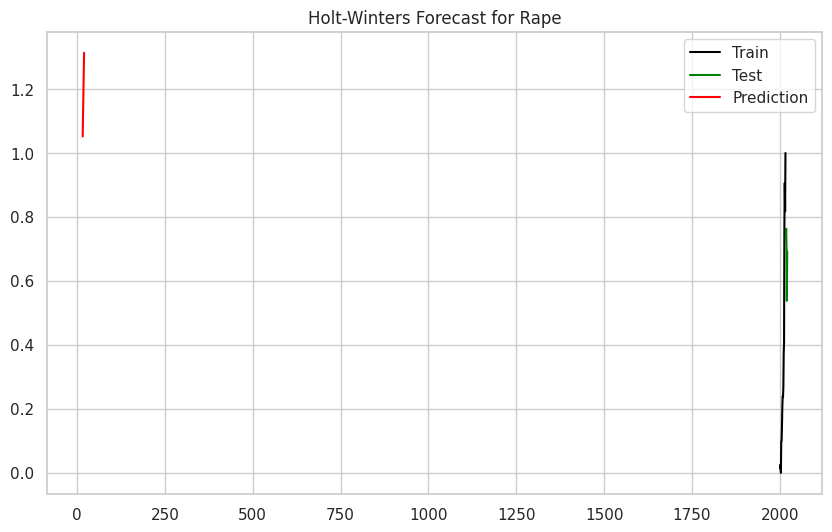

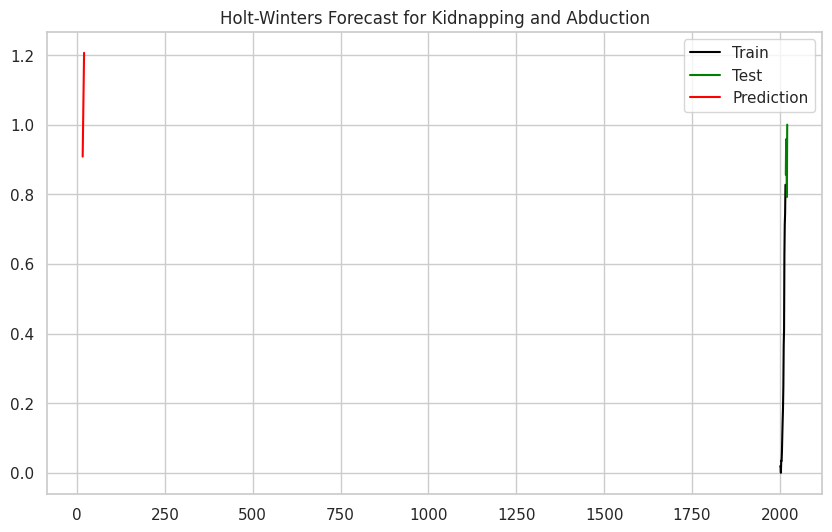

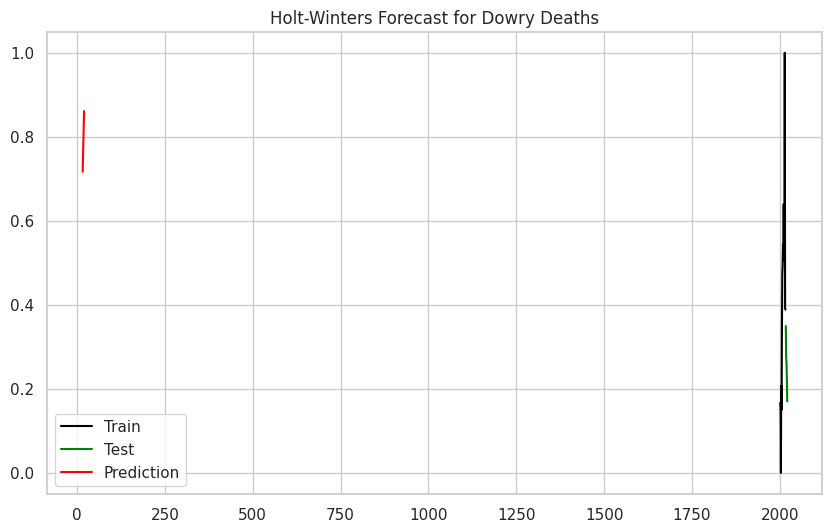

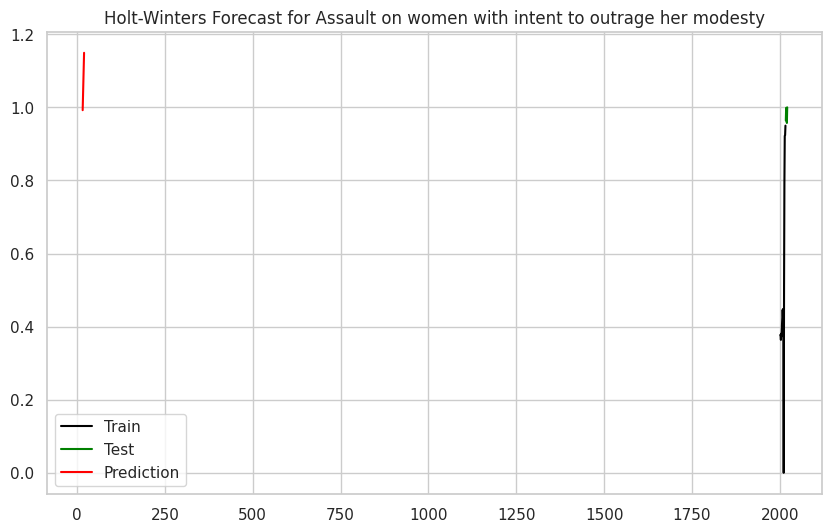

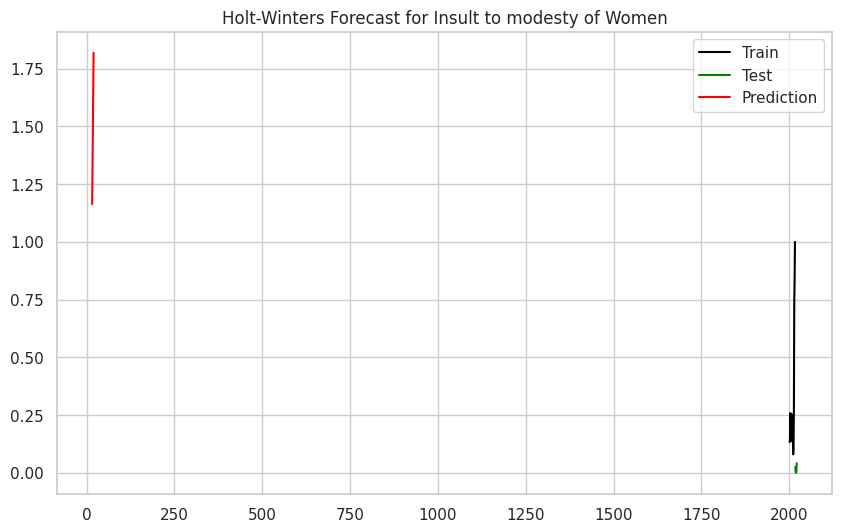

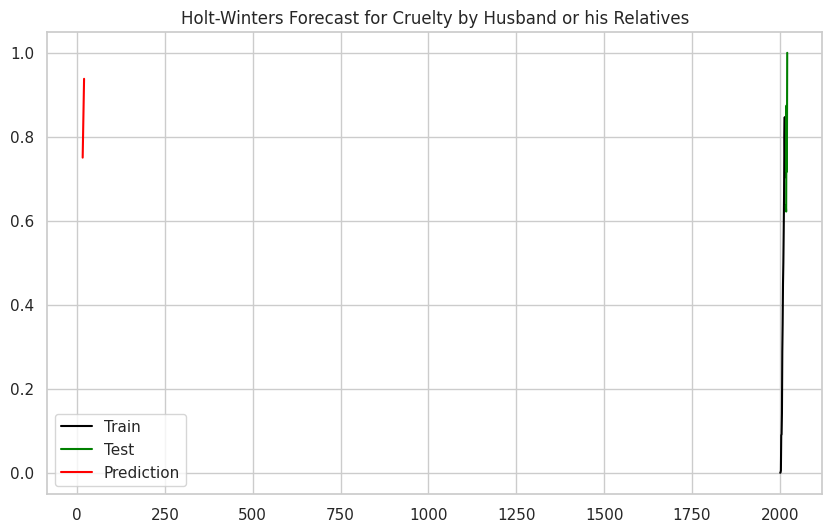

Model Evaluation (MAE and RMSE) for each crime type:
Rape: MAE = 0.50, RMSE = 0.52
Kidnapping and Abduction: MAE = 0.14, RMSE = 0.18
Dowry Deaths: MAE = 0.53, RMSE = 0.54
Assault on women with intent to outrage her modesty: MAE = 0.09, RMSE = 0.10
Insult to modesty of Women: MAE = 1.48, RMSE = 1.49
Cruelty by Husband or his Relatives: MAE = 0.11, RMSE = 0.13


In [ ]:
# Step 3: Train/Test Split
train_data = scaled_data.iloc[:int(len(scaled_data) * 0.8)]
test_data = scaled_data.iloc[int(len(scaled_data) * 0.8):]

# Forecasting and Model Evaluation
results = {}
for crime_type in crime_types:
    model = ExponentialSmoothing(train_data[crime_type], trend='add', seasonal=None).fit()
    test_predictions = model.forecast(len(test_data))
    mae = mean_absolute_error(test_data[crime_type], test_predictions)
    rmse = mean_squared_error(test_data[crime_type], test_predictions, squared=False)
    results[crime_type] = {'MAE': mae, 'RMSE': rmse}

    plt.figure(figsize=(10, 6))
    plt.plot(train_data[crime_type], label='Train', color='black')
    plt.plot(test_data[crime_type], label='Test', color='green')
    plt.plot(test_predictions, label='Prediction', color='red')
    plt.title(f'Holt-Winters Forecast for {crime_type}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

print("Model Evaluation (MAE and RMSE) for each crime type:")
for crime_type, metrics in results.items():
    print(f"{crime_type}: MAE = {metrics['MAE']:.2f}, RMSE = {metrics['RMSE']:.2f}")


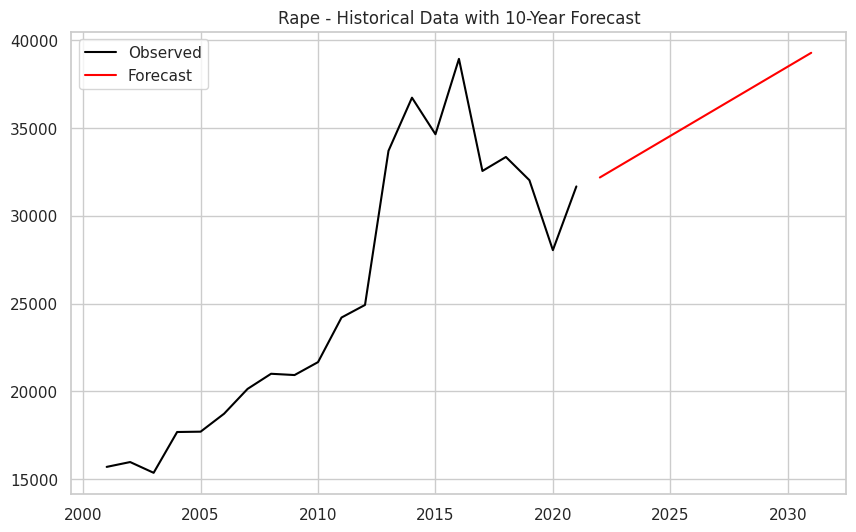

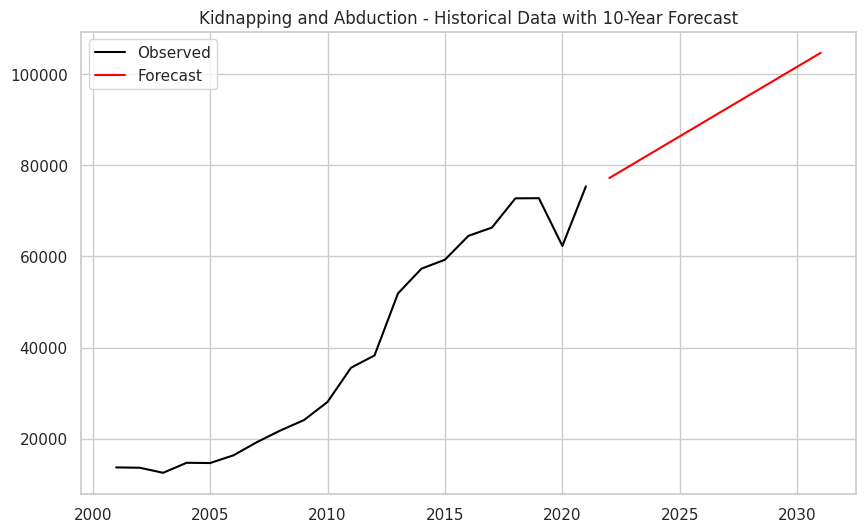

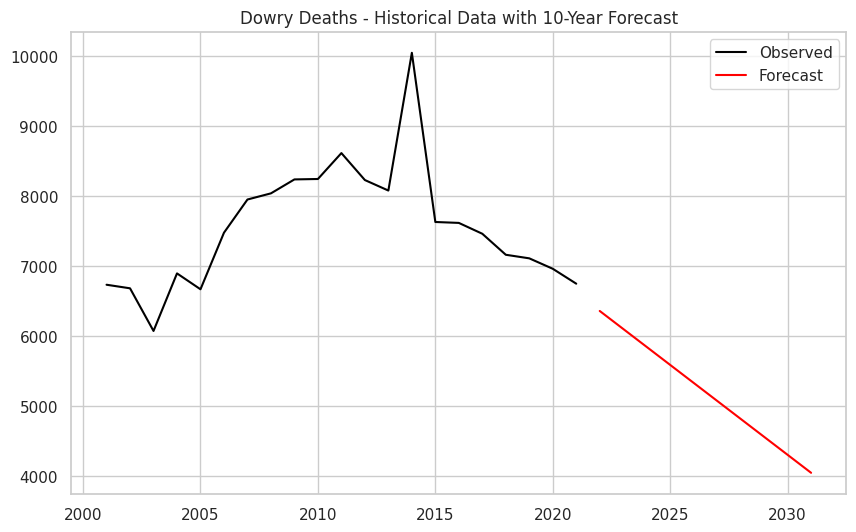

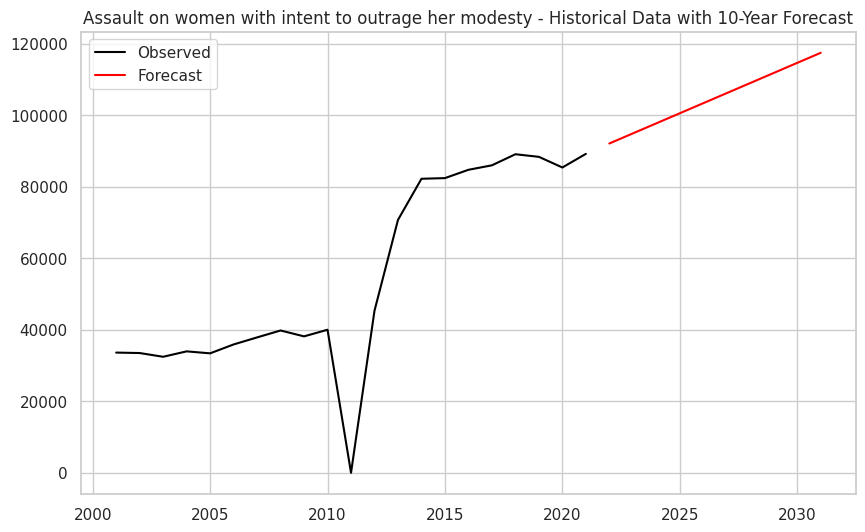

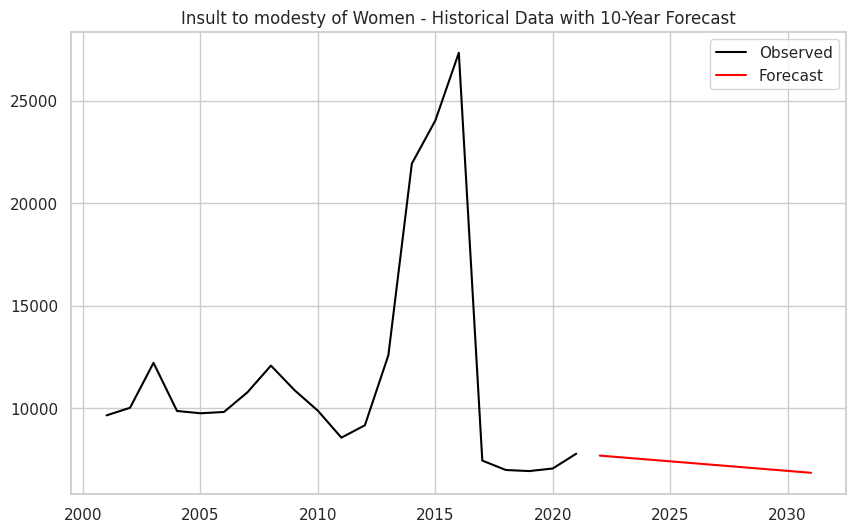

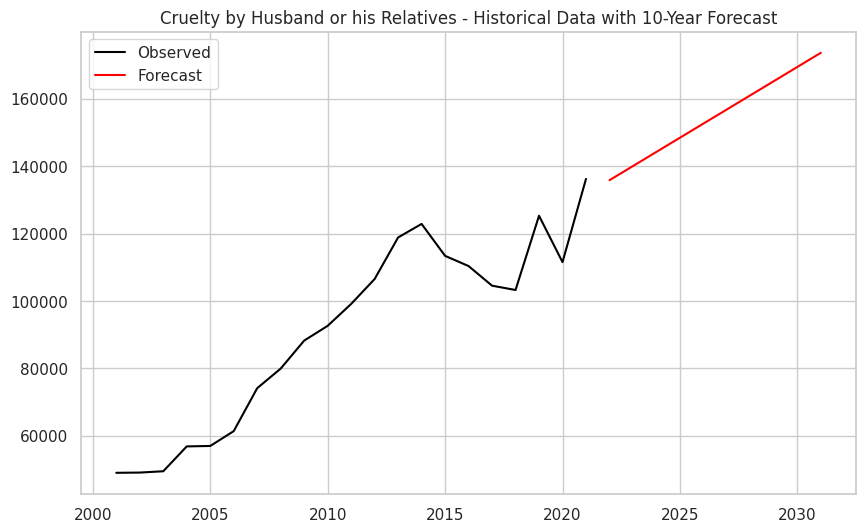

10-Year Forecasts for each crime type:
Rape Forecast for next 10 years: [32186.90550882 32976.39120768 33765.87690654 34555.3626054
 35344.84830426 36134.33400312 36923.81970198 37713.30540084
 38502.7910997  39292.27679856]
Kidnapping and Abduction Forecast for next 10 years: [ 77209.39580973  80263.52852141  83317.66123309  86371.79394476
  89425.92665644  92480.05936811  95534.19207979  98588.32479147
 101642.45750314 104696.59021482]
Dowry Deaths Forecast for next 10 years: [6363.44131563 6106.65672759 5849.87213956 5593.08755153 5336.30296349
 5079.51837546 4822.73378743 4565.94919939 4309.16461136 4052.38002333]
Assault on women with intent to outrage her modesty Forecast for next 10 years: [ 92105.05145782  94922.76095749  97740.47045715 100558.17995682
 103375.88945649 106193.59895616 109011.30845583 111829.0179555
 114646.72745516 117464.43695483]
Insult to modesty of Women Forecast for next 10 years: [7694.67154971 7601.34311158 7508.01467346 7414.68623533 7321.3577972
 7228.

In [ ]:
# Step 4: Final Model for 10-Year Forecast
forecasts = {}
for crime_type in crime_types:
    final_model = ExponentialSmoothing(scaled_data[crime_type], trend='add', seasonal=None).fit()
    future_forecast = final_model.forecast(10)  # Forecast for the next 10 years

    # Inverse transform forecast to original scale
    scaler.fit(annual_data[crime_type].values.reshape(-1, 1))
    forecast_rescaled = scaler.inverse_transform(future_forecast.values.reshape(-1, 1))
    forecasts[crime_type] = forecast_rescaled.flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(annual_data[crime_type], label='Observed', color='black')
    future_years = range(annual_data.index.max() + 1, annual_data.index.max() + 11)
    plt.plot(pd.Series(forecast_rescaled.flatten(), index=future_years), label='Forecast', color='red')
    plt.title(f'{crime_type} - Historical Data with 10-Year Forecast')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

print("10-Year Forecasts for each crime type:")
for crime_type, forecast in forecasts.items():
    print(f"{crime_type} Forecast for next 10 years: {forecast}")


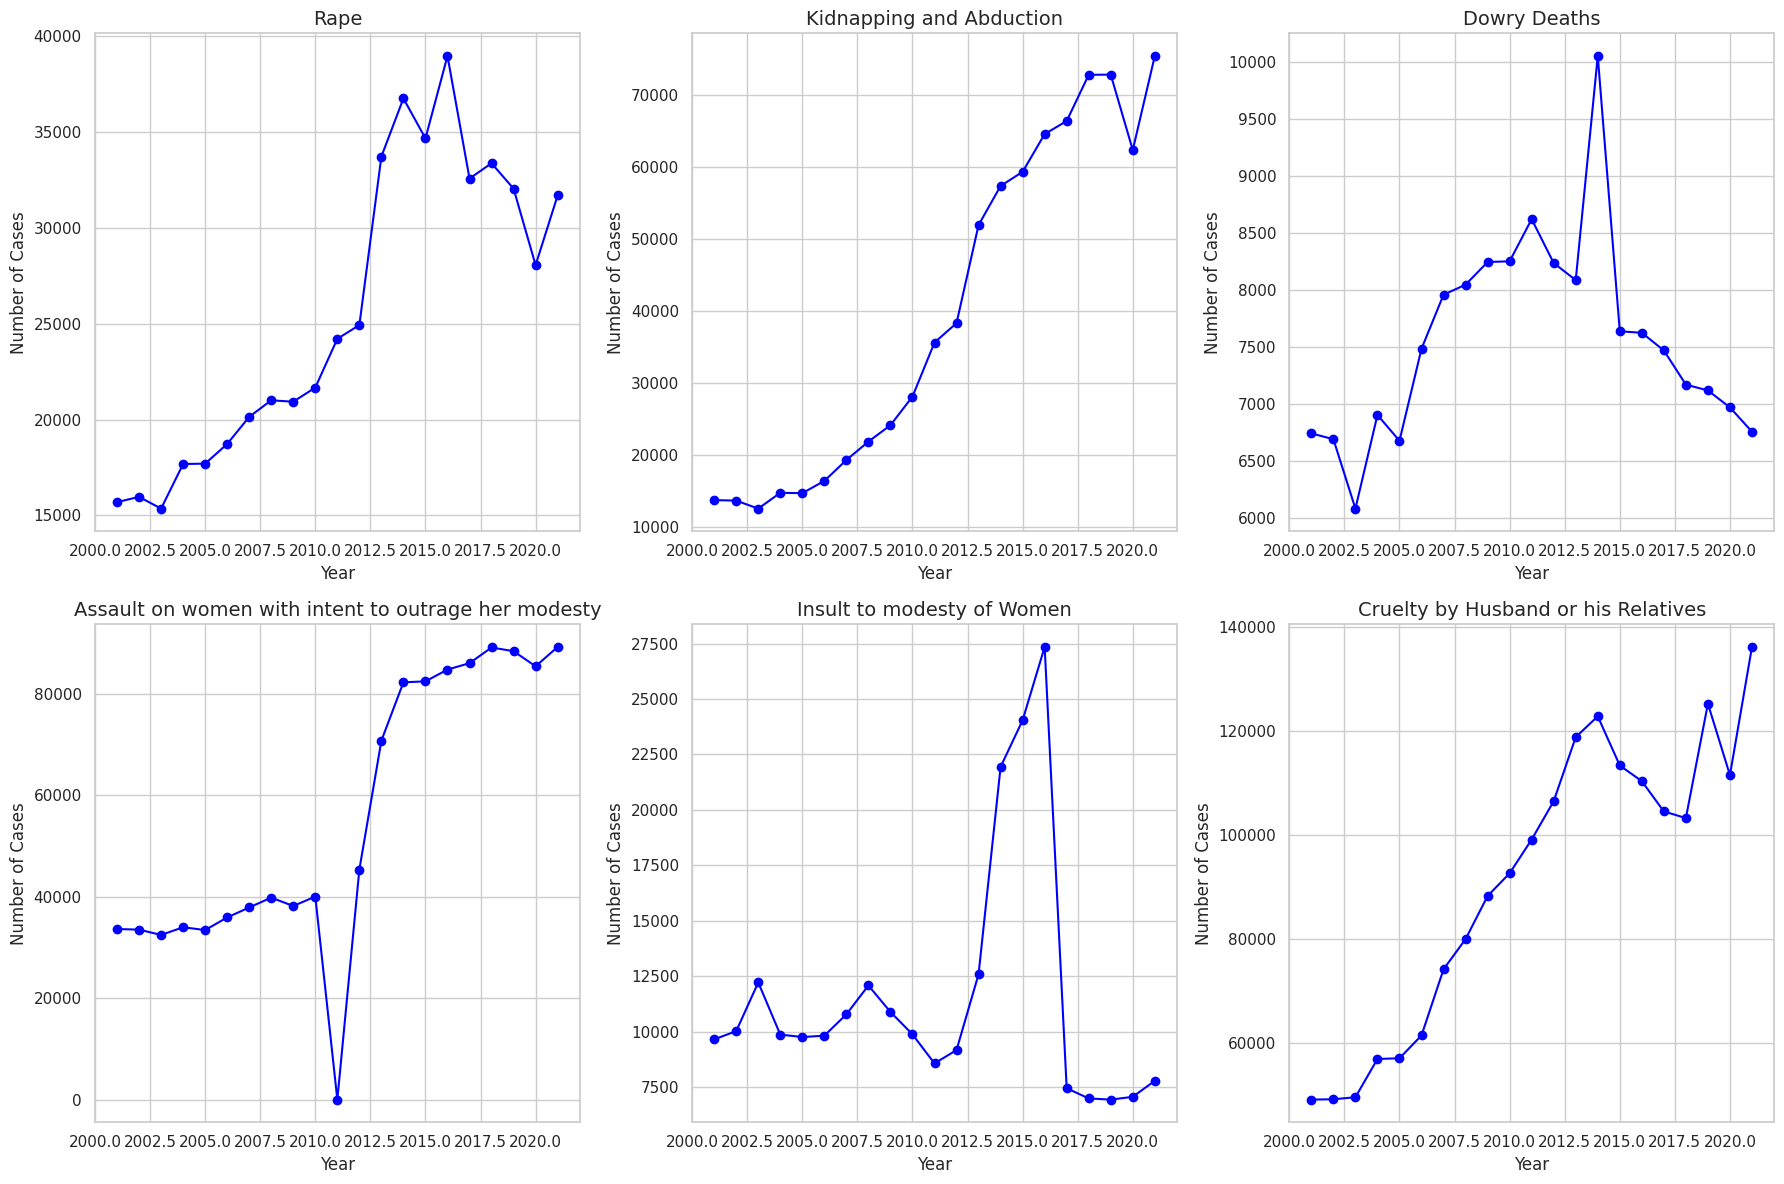

In [ ]:
import matplotlib.pyplot as plt

# Define crime types
crime_types = [
    'Rape',
    'Kidnapping and Abduction',
    'Dowry Deaths',
    'Assault on women with intent to outrage her modesty',
    'Insult to modesty of Women',
    'Cruelty by Husband or his Relatives'
]

# Prepare a figure with subplots arranged in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot trends for each crime type from 2001 to 2021
for i, crime in enumerate(crime_types):
    # Aggregate data for each crime type over the years
    crime_data = df.groupby('Year')[crime].sum()

    # Plot historical data
    axes[i].plot(crime_data.index, crime_data.values, marker='o', color='blue')

    # Set titles, labels, and styling to match the example format
    axes[i].set_title(f'{crime}', fontsize=14)
    axes[i].set_xlabel('Year', fontsize=12)
    axes[i].set_ylabel('Number of Cases', fontsize=12)
    axes[i].grid(True)

# Adjust layout to ensure no overlap and improve spacing
plt.tight_layout()
plt.show()


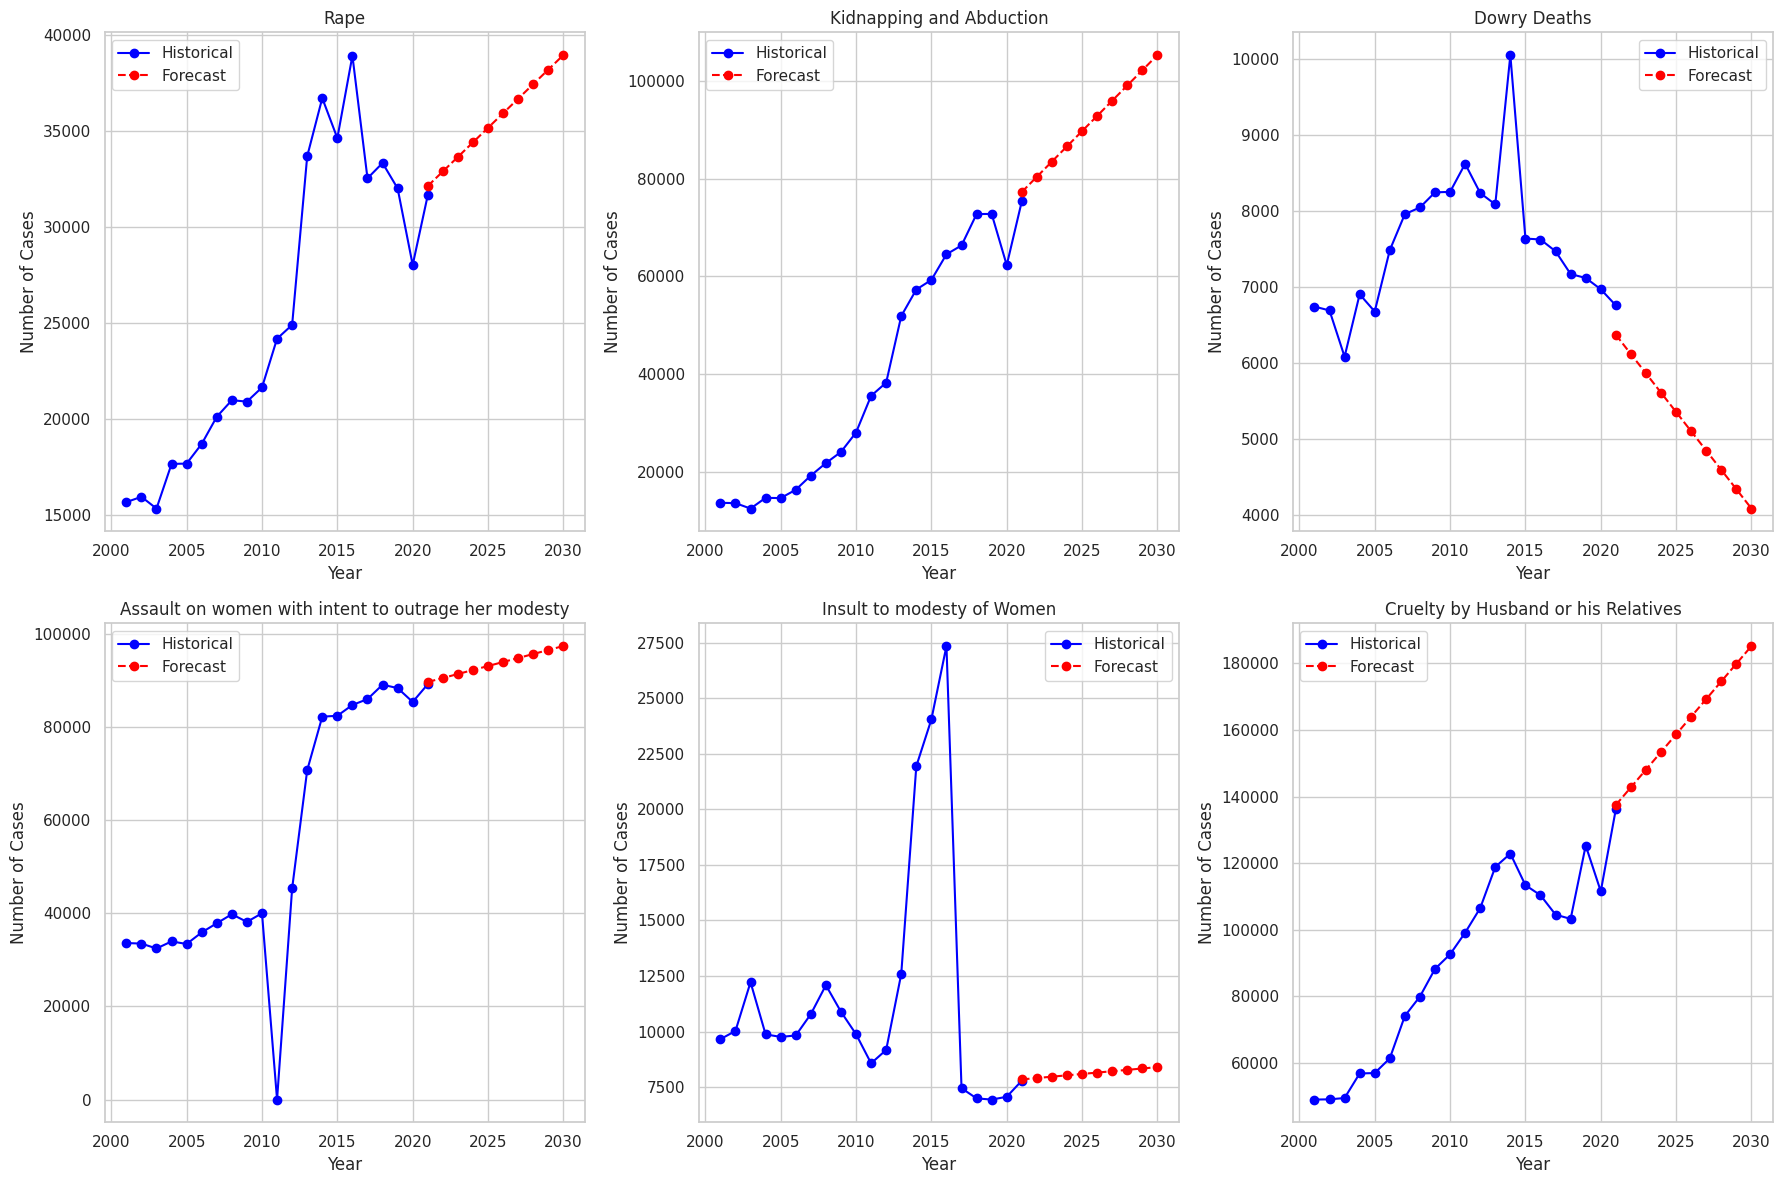

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define crime types
crime_types = ['Rape', 'Kidnapping and Abduction', 'Dowry Deaths',
               'Assault on women with intent to outrage her modesty',
               'Insult to modesty of Women', 'Cruelty by Husband or his Relatives']

# Prepare a figure with subplots for each crime type
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Forecasting and plotting for each crime type
for i, crime in enumerate(crime_types):
    # Aggregate data for each crime type over the years
    crime_data = df.groupby('Year')[crime].sum()

    # Fit the Holt-Winters model to historical data
    model = ExponentialSmoothing(crime_data, trend='add', seasonal=None).fit()

    # Forecast for 10 years into the future (2021-2030)
    future_forecast = model.forecast(10)

    # Plot historical data
    axes[i].plot(crime_data.index, crime_data.values, marker='o', color='blue', label='Historical')

    # Plot forecasted data
    forecast_years = range(2021, 2031)
    axes[i].plot(forecast_years, future_forecast.values, marker='o', color='red', linestyle='--', label='Forecast')

    # Set titles and labels
    axes[i].set_title(crime)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Number of Cases')
    axes[i].grid(True)
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


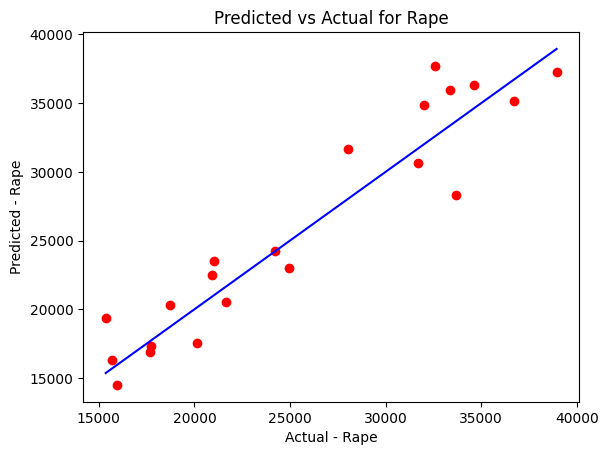

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


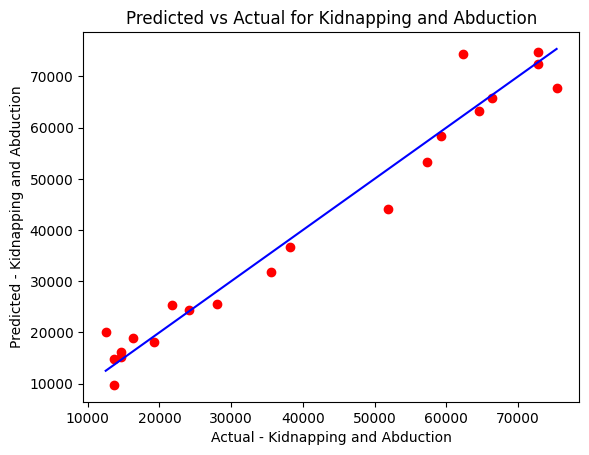

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


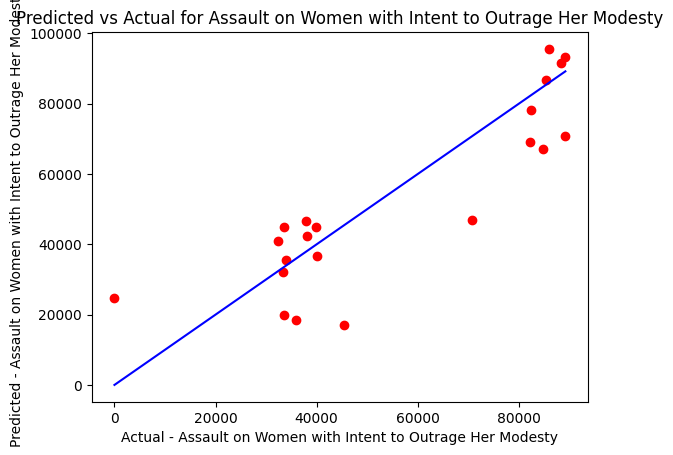

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


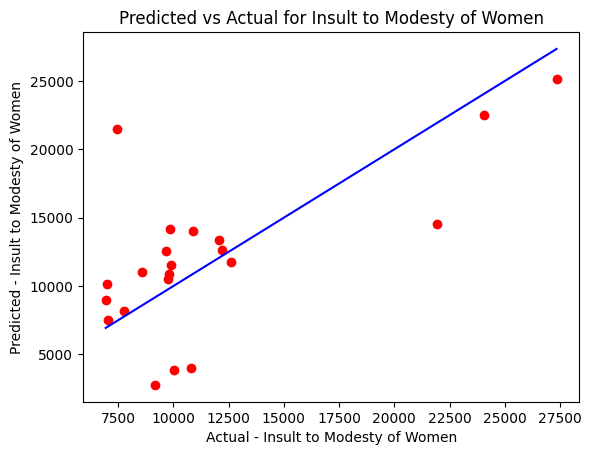

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


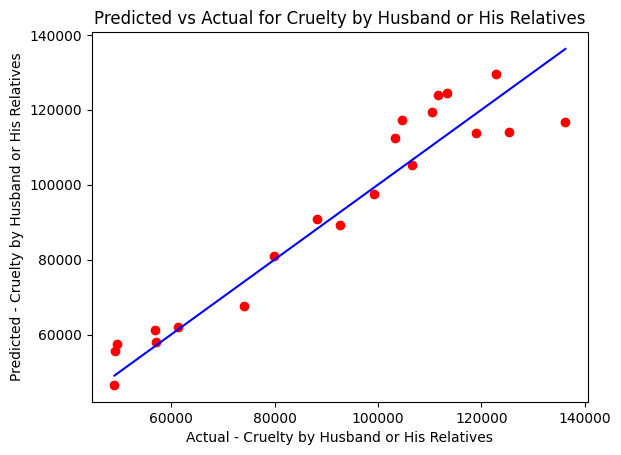

In [2]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/CrimesOnWomenData-dataset.csv')

# Aggregate data by year
df_yearly = df.groupby('Year').sum().reset_index()

# Define a function to forecast and plot
def forecast_and_plot(actual_values, title, ylabel):
    # Train the Exponential Smoothing model on the actual values
    model = ExponentialSmoothing(actual_values, trend="add", seasonal="add", seasonal_periods=5).fit()
    predictions = model.fittedvalues

    # Plot predicted vs actual values
    plt.scatter(actual_values, predictions, color='red')
    plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='blue')
    plt.xlabel(f"Actual - {ylabel}")
    plt.ylabel(f"Predicted - {ylabel}")
    plt.title(title)
    plt.show()

# Apply the function for each crime category
forecast_and_plot(df_yearly['Rape'], "Predicted vs Actual for Rape", "Rape")
forecast_and_plot(df_yearly['Kidnapping and Abduction'], "Predicted vs Actual for Kidnapping and Abduction", "Kidnapping and Abduction")
forecast_and_plot(df_yearly['Assault on women with intent to outrage her modesty'], "Predicted vs Actual for Assault on Women with Intent to Outrage Her Modesty", "Assault on Women with Intent to Outrage Her Modesty")
forecast_and_plot(df_yearly['Insult to modesty of Women'], "Predicted vs Actual for Insult to Modesty of Women", "Insult to Modesty of Women")
forecast_and_plot(df_yearly['Cruelty by Husband or his Relatives'], "Predicted vs Actual for Cruelty by Husband or His Relatives", "Cruelty by Husband or His Relatives")


In [ ]:
# Predictive Modeling (Random Forest)
# Prepare dataset for Random Forest
statewise_data = df.groupby(['State', 'Year']).sum().reset_index()
X = statewise_data[['Year', 'Kidnapping and Abduction', 'Dowry Deaths',
                    'Assault on women with intent to outrage her modesty',
                    'Insult to modesty of Women', 'Cruelty by Husband or his Relatives']]
y = statewise_data['Rape']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nRandom Forest - Mean Absolute Error: {mae:.2f}")
print(f"Random Forest - R² Score: {r2:.2f}")


Random Forest - Mean Absolute Error: 171.06
Random Forest - R² Score: 0.90
